In [38]:
import cv2
import numpy as np
from skimage import img_as_float
from skimage.exposure import rescale_intensity
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import pickle
import cv2 as cv

In [39]:
# load list of charter img paths

folders = [
    '../images/writable_area/fr_notary',
    '../images/writable_area/fr_papal',
    '../images/writable_area/fr_other',
    '../images/writable_area/at_notary',
    '../images/writable_area/at_papal',
    '../images/writable_area/at_other'
]
if isinstance(folders, str):
    folders = [folders]
charter_list = []
for folder in folders:
    files = os.listdir(folder)
    full_paths = [os.path.abspath(os.path.join(folder, f)) for f in files]
    charter_list.extend(full_paths)

charter_list

['/home/tschernn/images/writable_area/fr_notary/wa_62f113115f5d2e4ead5b5c9e256bbe1e2.jpg',
 '/home/tschernn/images/writable_area/fr_notary/wa_c7e12db9d6a8c09138e67b77818b1128.jpg',
 '/home/tschernn/images/writable_area/fr_notary/wa_1a3f5a81f9bb7fabfe3012b2eccf4b17.jpg',
 '/home/tschernn/images/writable_area/fr_notary/wa_667364aabe89e6dc65e939b80b212fa3.jpg',
 '/home/tschernn/images/writable_area/fr_notary/wa_899fd4f8624fbaf5c0e426def2c0f493.jpg',
 '/home/tschernn/images/writable_area/fr_notary/wa_abecb7d73e17bb5f70cb7c9052cad533.jpg',
 '/home/tschernn/images/writable_area/fr_notary/wa_da478d335f3d171dab933ef1b82550f8.jpg',
 '/home/tschernn/images/writable_area/fr_notary/wa_62f113115f5d2e4ead5b5c9e256bbe1e.jpg',
 '/home/tschernn/images/writable_area/fr_notary/wa_102c6f15d88c100d2ee20b7897c98b2f.jpg',
 '/home/tschernn/images/writable_area/fr_notary/wa_8415479990e86749e4db7af6977979a9.jpg',
 '/home/tschernn/images/writable_area/fr_notary/wa_14915356f95bbac38361a0dc861e5974.jpg',
 '/home/t

In [40]:
charter_path = 'pickles/charter_list.pkl'

### export data as pickle file

with open(charter_path,'wb') as file:
    pickle.dump(charter_list, file)
    print(f'Saved features as {file.name}.')

Saved features as pickles/charter_list.pkl.


In [41]:
def binarize_dir_adaptive(image):
        
    # Apply adaptive thresholding
    img_thresh = cv.adaptiveThreshold(
        image,
        maxValue=255,
        adaptiveMethod=cv.ADAPTIVE_THRESH_GAUSSIAN_C,  # or cv.ADAPTIVE_THRESH_MEAN_C
        thresholdType=cv.THRESH_BINARY,
        blockSize=45,     # size of neighborhood (must be odd, e.g., 11, 15, 35...)
        C=10              # constant subtracted from mean; tweak for contrast
    )
    return img_thresh

In [42]:
def clahe(image):      
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    processed_image = clahe.apply(image)
    
    return processed_image

In [43]:
def retinex(image):      

    # Convert to float
    float_img = img_as_float(image)
    
    # Gaussian blur to estimate illumination
    sigma = 30
    blurred = cv2.GaussianBlur(float_img, (0, 0), sigmaX=sigma, sigmaY=sigma)
    
    # Avoid division by zero
    retinex = np.clip(float_img / (blurred + 1e-6), 0, 10)
    
    # Rescale to [0,255] for output
    processed_image = rescale_intensity(retinex, out_range=(0, 255)).astype(np.uint8)

    return processed_image

In [44]:
def resize_and_pad(image, size=224, padding_color=255):
    # Convert to PIL Image if not already
    if not isinstance(image, Image.Image):
        image = Image.fromarray(image)
    
    # Resize while maintaining aspect ratio
    image.thumbnail((size, size), Image.LANCZOS)
    
    # Create new square canvas and paste
    delta_w = size - image.width
    delta_h = size - image.height
    padding = (delta_w // 2, delta_h // 2, delta_w - delta_w // 2, delta_h - delta_h // 2)
    
    new_image = ImageOps.expand(image, padding, fill=padding_color)
    return new_image

In [45]:
def deskew(image):        
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    
    (h, w) = image.shape
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    deskewed = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    
    return deskewed

In [46]:
for folder in folders:
    os.makedirs(f'../images/preprocessed_imgs/clahe_retinex/{folder.partition("images/")[2]}', exist_ok=True)
    
    for img_path in charter_list:
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        #image = binarize_dir_adaptive(image)
        #image = deskew(image)
        image = clahe(image)
        image = retinex(image)
        #image = resize_and_pad(image)
        img_array = np.array(image)
        out_path = f'../images/preprocessed_imgs/clahe_retinex/{img_path.partition("images/")[2]}'
        cv.imwrite(out_path, img_array)
        print(f'Successfully wrote {out_path}')

Successfully wrote ../images/preprocessed_imgs/clahe_retinex/writable_area/fr_notary/wa_62f113115f5d2e4ead5b5c9e256bbe1e2.jpg
Successfully wrote ../images/preprocessed_imgs/clahe_retinex/writable_area/fr_notary/wa_c7e12db9d6a8c09138e67b77818b1128.jpg
Successfully wrote ../images/preprocessed_imgs/clahe_retinex/writable_area/fr_notary/wa_1a3f5a81f9bb7fabfe3012b2eccf4b17.jpg
Successfully wrote ../images/preprocessed_imgs/clahe_retinex/writable_area/fr_notary/wa_667364aabe89e6dc65e939b80b212fa3.jpg
Successfully wrote ../images/preprocessed_imgs/clahe_retinex/writable_area/fr_notary/wa_899fd4f8624fbaf5c0e426def2c0f493.jpg
Successfully wrote ../images/preprocessed_imgs/clahe_retinex/writable_area/fr_notary/wa_abecb7d73e17bb5f70cb7c9052cad533.jpg
Successfully wrote ../images/preprocessed_imgs/clahe_retinex/writable_area/fr_notary/wa_da478d335f3d171dab933ef1b82550f8.jpg
Successfully wrote ../images/preprocessed_imgs/clahe_retinex/writable_area/fr_notary/wa_62f113115f5d2e4ead5b5c9e256bbe1e.jpg

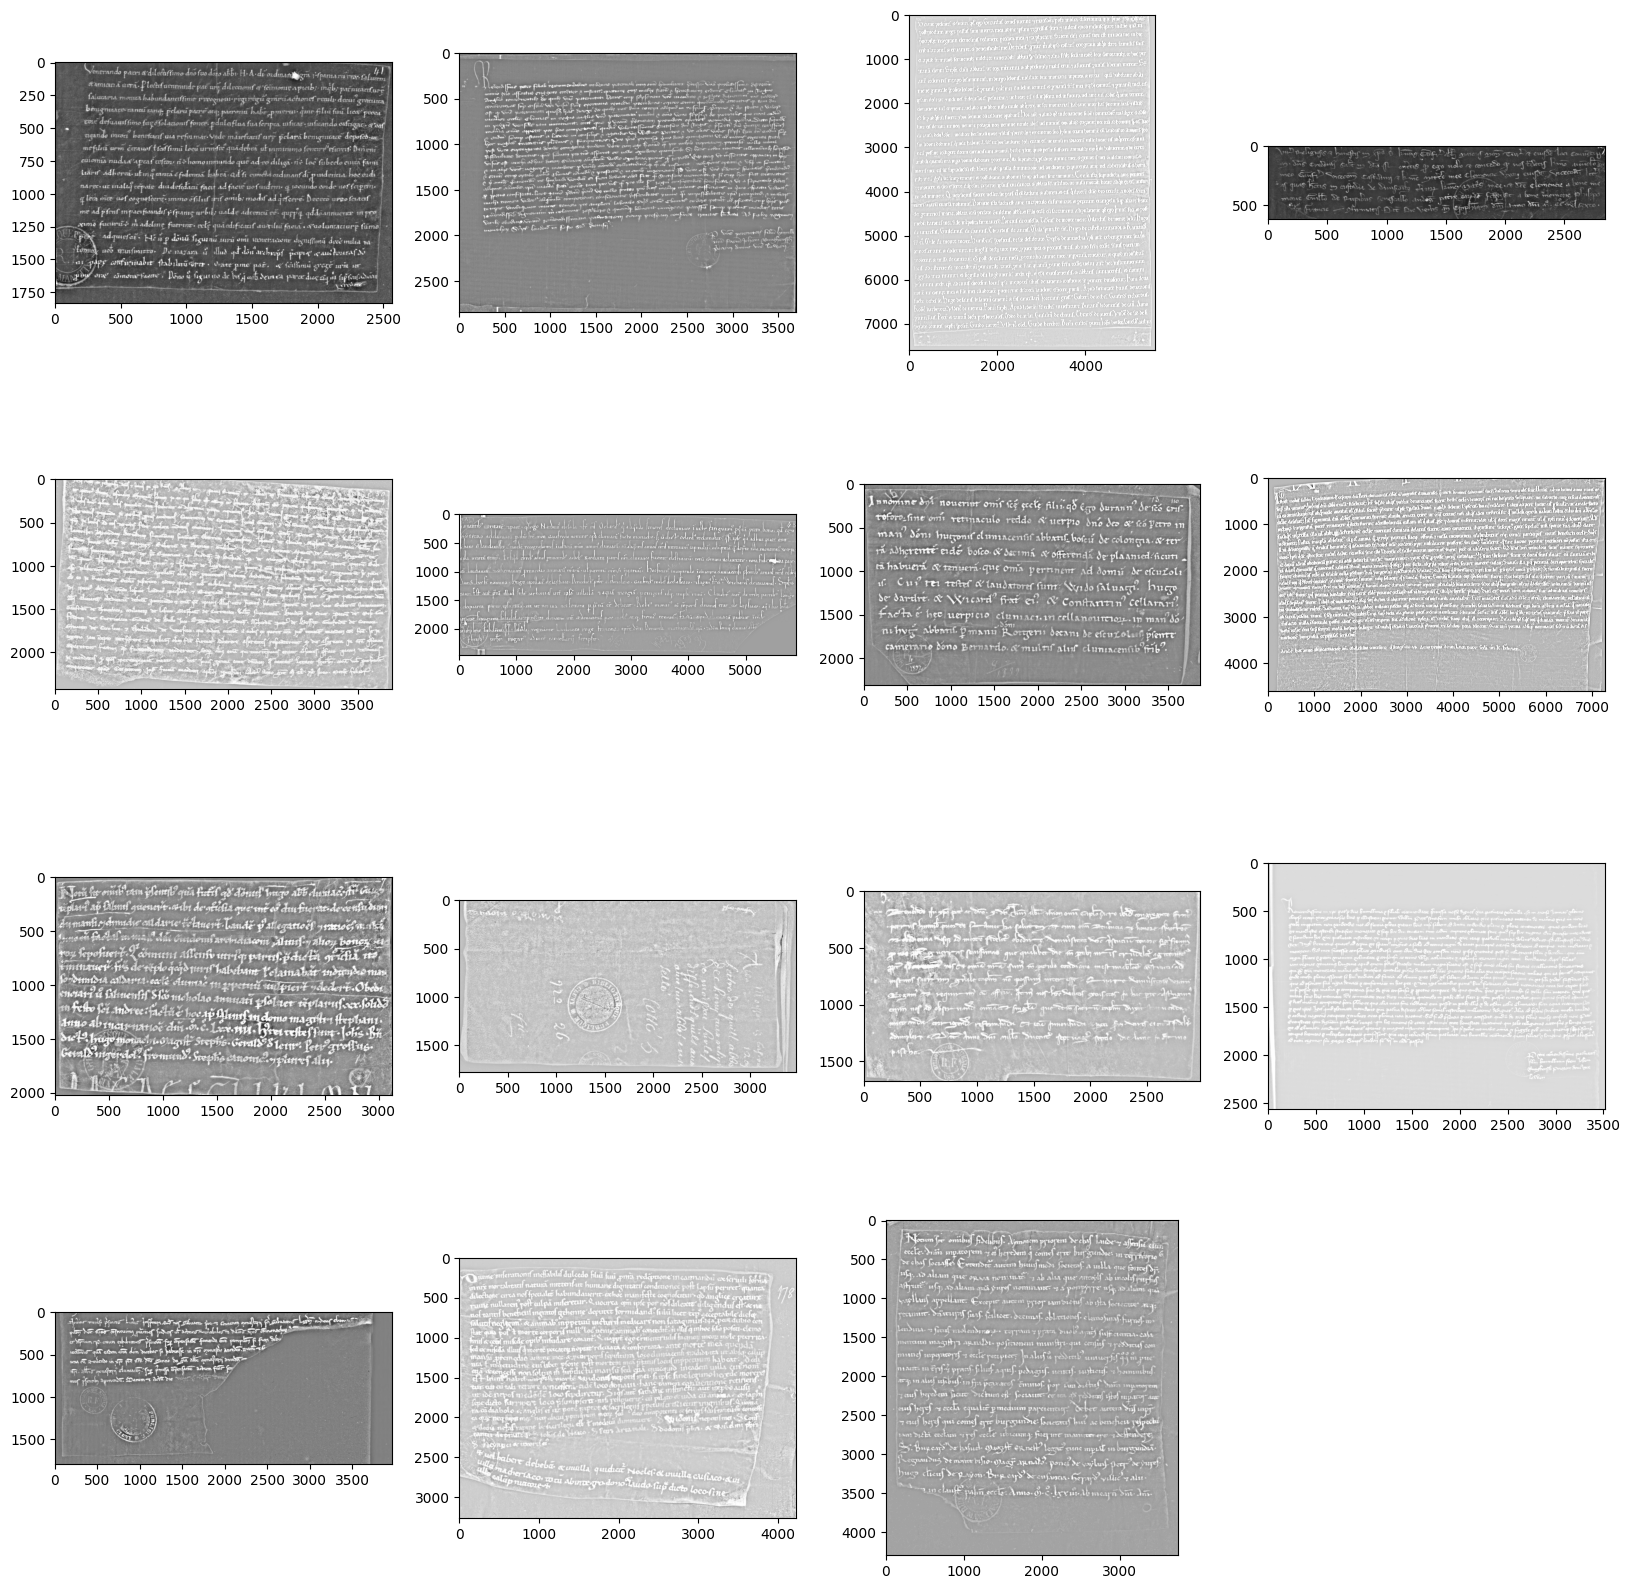

In [47]:
### visualize results
result_dir = os.listdir('../images/preprocessed_imgs/clahe_retinex/writable_area/fr_other')
plt.figure(figsize = (20, 20));
num = 16 # num of items to visualize
for i in range(1, num): 
    plt.subplot(4, 4, i); # number of rows, number of columns, item number
    img = mpimg.imread('../images/preprocessed_imgs/clahe_retinex/writable_area/fr_other/' + result_dir[i])
    plt.imshow(img, cmap = plt.cm.binary);
plt.show()